<a href="https://colab.research.google.com/github/xAn-x/VisionLab/blob/master/LeNet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [ ]:
transforms=T.Compose([
    T.ToTensor(),
    T.Resize((32,32)),
    T.Normalize(0.5,0.5)
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True, transform=transforms)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=False,transform=transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 85720641.56it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38009317.17it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31677627.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4980530.40it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
for batch in train_dataloader:
  print(batch[0].shape)
  break

torch.Size([64, 1, 32, 32])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  npimg = img.numpy()
  npimg = (npimg+0.5)*0.5 # denorm
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

def visualize_batch(dataloader):
  images, labels = next(iter(dataloader))
  grid = torchvision.utils.make_grid(images)
  imshow(grid)

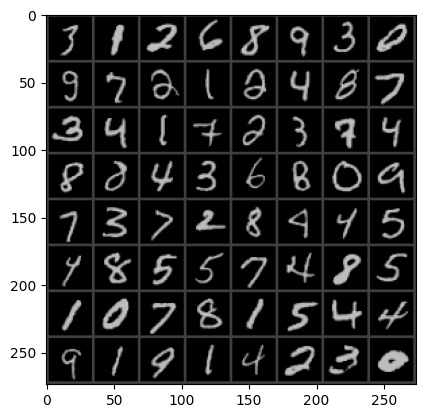

In [ ]:
visualize_batch(train_dataloader)

In [ ]:
class LeNet(nn.Module):
  def __init__(self,in_channels,output_size):
    super(LeNet,self).__init__()
    self.pool=nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
    self.relu=nn.ReLU()

    self.conv1=nn.Conv2d(in_channels,out_channels=6,kernel_size=(5,5),stride=(1,1),padding=(0,0))
    self.conv2=nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1),padding=(0,0))
    self.conv3=nn.Conv2d(in_channels=16,out_channels=120,kernel_size=(5,5),stride=(1,1),padding=(0,0))
    self.linear1=nn.Linear(120,84)
    self.linear2=nn.Linear(84,10)


  def forward(self,x):
    x=self.relu(self.conv1(x))
    x=self.pool(x)
    x=self.relu(self.conv2(x))
    x=self.pool(x)
    x=self.relu(self.conv3(x))
    x=x.reshape(x.shape[0],-1) # Flatten
    x=self.relu(self.linear1(x))
    out=self.linear2(x)

    return out


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [ ]:
model=LeNet(1,10)

model=model.to(device)

In [ ]:
import numpy as np

def train_model(model, train_dataloader, val_dataloader, epochs, device, optimizer, criterion):
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    for epoch in range(epochs):
        model.train()
        for batch in train_dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculate training accuracy after each epoch
        model.eval()
        with torch.no_grad():
            total_correct_train = 0
            total_train_samples = 0
            total_train_loss = 0.0
            for batch in train_dataloader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels.view(-1))

                total_train_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_correct_train += (predicted == labels).sum().item()
                total_train_samples += labels.size(0)

            train_loss.append(total_train_loss / len(train_dataloader))
            train_accuracy.append(total_correct_train / total_train_samples)

        # Calculate validation accuracy after each epoch
        model.eval()
        with torch.no_grad():
            total_correct_val = 0
            total_val_samples = 0
            total_val_loss = 0.0
            for batch in val_dataloader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_correct_val += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

            val_loss.append(total_val_loss / len(val_dataloader))
            val_accuracy.append(total_correct_val / total_val_samples)

        print(f"Epoch: {epoch + 1}")
        print(f"Training Loss: {train_loss[-1]:.4f}")
        print(f"Training Accuracy: {train_accuracy[-1]:.4f}")
        print(f"Validation Loss: {val_loss[-1]:.4f}")
        print(f"Validation Accuracy: {val_accuracy[-1]:.4f}\n")

    return {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy
    }


In [ ]:
# Define optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = F.cross_entropy

# Train the model
hist = train_model(model, train_dataloader, val_dataloader, epochs=5, device=device, optimizer=optimizer, criterion=criterion)

Epoch: 1
Training Loss: 0.0877
Training Accuracy: 0.9725
Validation Loss: 0.0804
Validation Accuracy: 0.9736

Epoch: 2
Training Loss: 0.0703
Training Accuracy: 0.9775
Validation Loss: 0.0623
Validation Accuracy: 0.9798

Epoch: 3
Training Loss: 0.0353
Training Accuracy: 0.9891
Validation Loss: 0.0399
Validation Accuracy: 0.9864

Epoch: 4
Training Loss: 0.0385
Training Accuracy: 0.9877
Validation Loss: 0.0413
Validation Accuracy: 0.9872

Epoch: 5
Training Loss: 0.0277
Training Accuracy: 0.9915
Validation Loss: 0.0342
Validation Accuracy: 0.9889



In [ ]:
def visualize_metric(hist,metric):
  plt.plot(hist[f"train_{metric}"],"r*--",label=f"train_{metric}")
  plt.plot(hist[f"val_{metric}"],"b*--",label=f"val_{metric}")
  plt.legend()

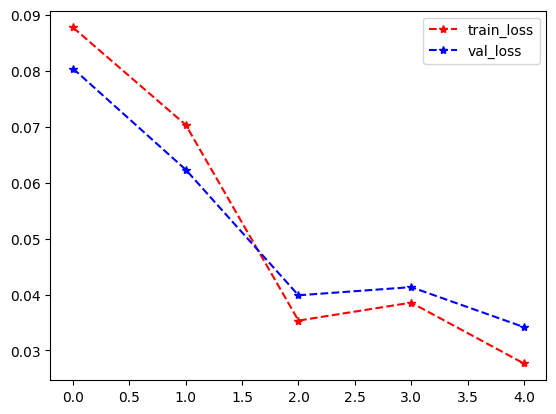

In [ ]:
visualize_metric(hist,"loss")

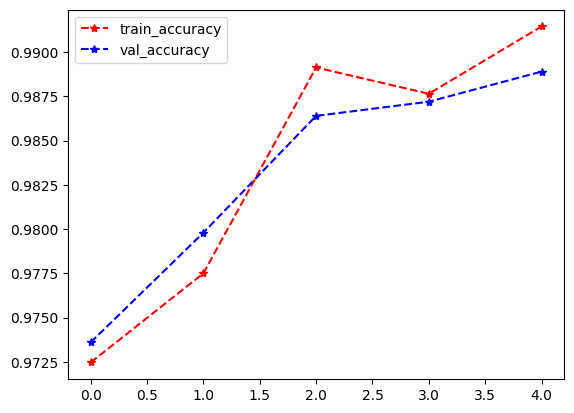

In [ ]:
visualize_metric(hist,"accuracy")

## `There is lot to improvements that can be done but since this is for me learning purpouses , I will leave it here only 😅`